In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/test.csv")
display(train.head())
display(test.head())

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,...,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,...,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,...,1,0,0,0,0,0,0,0,0,0


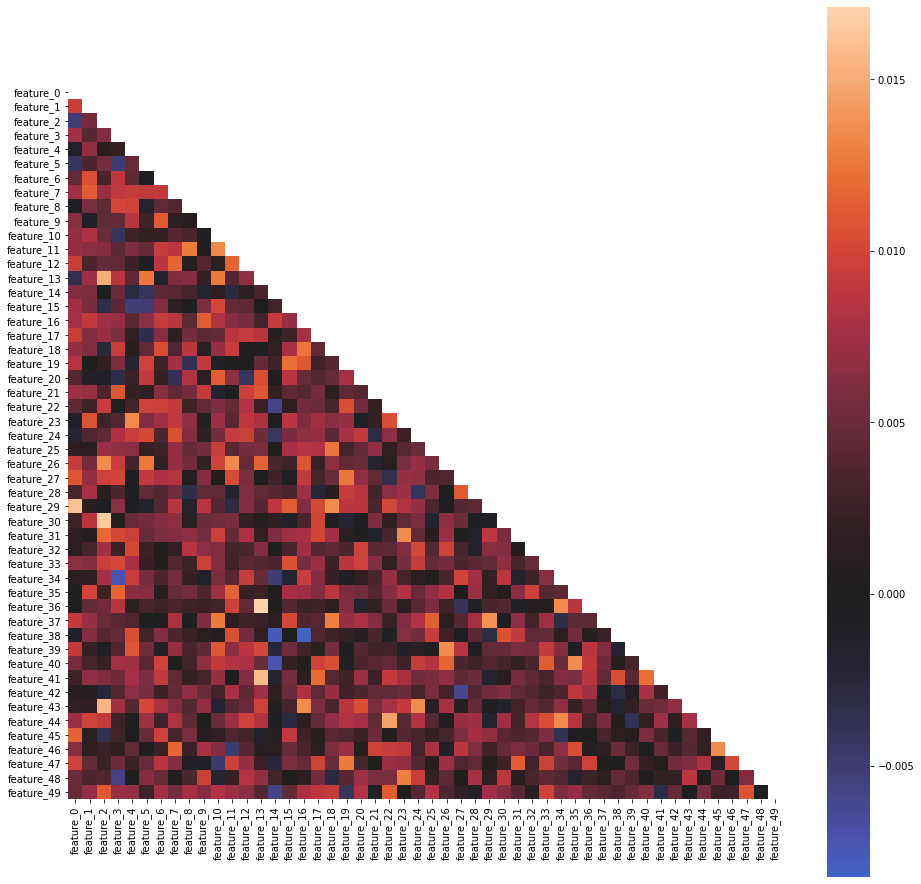

In [4]:
plt.figure(figsize=(16,16))
features = [col for col in train.columns if col not in ['id']]
corr = train[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, square=True, center=0)
plt.show()

In [5]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

In [6]:
y = train[['target']].apply(label_encoder)

In [7]:
X = train.drop(['id', 'target'], axis=1)
X.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,0,0,1,0,1,0,0,0,0,0,...,3,0,0,21,0,0,0,0,0,0
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,13,2,0
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
def objective(trial, data=X, target=y):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)
    
    params = {'iterations': 5000,
              'depth': trial.suggest_int("depth", 3, 20),
              'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.0001, 25, log=True),
              'bagging_temperature': trial.suggest_float("bagging_temperature", 0, 100),
#               'auto_class_weights': trial.suggest_categorical('auto_class_weights', [None,'Balanced','SqrtBalanced']),
              'grow_policy': 'Lossguide',
              'loss_function': 'MultiClass',
              'bootstrap_type': 'Poisson',
              'use_best_model': True,
              'task_type': 'GPU', 
#               'cat_features': high,
              'eval_metric': 'MultiClass',
              'learning_rate': trial.suggest_uniform('learning_rate' , 1e-5 , 1.0),
              'max_bin': trial.suggest_int('max_bin', 5, 700),
              'verbose':False,
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 600),
              'subsample': trial.suggest_uniform('subsample' , 1e-5 , 1.0)
             }
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(X_train, y_train, eval_set = [(X_val , y_val)], early_stopping_rounds = 400, verbose = False)
    preds =  cat_model.predict_proba(X_val)
    lgl = log_loss(y_val , preds)
    return lgl

In [9]:
# study = optuna.create_study(direction='minimize', study_name='catboostclassifier')
# study.optimize(objective, n_trials=30)

In [10]:
# best_params = study.best_trial.params
# best_params['iterations'] = 5000
# best_params['task_type'] = 'GPU'
# best_params['loss_function'] = 'MultiClass'
# best_params['eval_metric'] = 'MultiClass'
# best_params['random_seed'] = 42
# best_params['bootstrap_type'] = 'Poisson'
# best_params['grow_policy'] = 'Lossguide'
# best_params['verbose'] = False
# best_params

```{'depth': 3,
 'l2_leaf_reg': 0.03395316126435454,
 'bagging_temperature': 9.059111809781673,
 'learning_rate': 0.09359349567369014,
 'max_bin': 215,
 'min_data_in_leaf': 458,
 'subsample': 0.6209914963728923,
 'iterations': 5000,
 'task_type': 'GPU',
 'loss_function': 'MultiClass',
 'eval_metric': 'MultiClass',
 'random_seed': 42,
 'bootstrap_type': 'Poisson',
 'grow_policy': 'Lossguide',
 'verbose': False}```

In [11]:
best_params = {'depth': 3,
 'l2_leaf_reg': 0.03395316126435454,
 'bagging_temperature': 9.059111809781673,
 'learning_rate': 0.09359349567369014,
 'max_bin': 215,
 'min_data_in_leaf': 458,
 'subsample': 0.6209914963728923,
 'iterations': 5000,
 'task_type': 'GPU',
 'loss_function': 'MultiClass',
 'eval_metric': 'MultiClass',
 'random_seed': 42,
 'bootstrap_type': 'Poisson',
 'grow_policy': 'Lossguide',
 'verbose': False}

In [12]:
preds = np.zeros((test.shape[0], 4))
lls = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    
    print("Fold {}:".format(fold))
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(**best_params)
    
    model.fit(X_train, y_train,
#              early_stopping_rounds=200,
             eval_set=[(X_val, y_val)],
             verbose=False)
    ll = log_loss(y_val, model.predict_proba(X_val))
    print("LogLoss: {}".format(ll))
    lls.append(ll)
    
    preds += model.predict_proba(test)
    
print("Average LogLoss: {}".format(np.mean(lls)))
    
preds /= skf.n_splits

Fold 0:
LogLoss: 1.0942289321780971
Fold 1:
LogLoss: 1.095060016595619
Fold 2:
LogLoss: 1.090006084954411
Fold 3:
LogLoss: 1.0945069887298484
Fold 4:
LogLoss: 1.0916946056438441
Fold 5:
LogLoss: 1.0890978770290727
Fold 6:
LogLoss: 1.0933854403604994
Fold 7:
LogLoss: 1.0892571193039897
Fold 8:
LogLoss: 1.0911583203814637
Fold 9:
LogLoss: 1.0916990116964804
Average LogLoss: 1.0920094396873326


In [13]:
submission = pd.DataFrame(preds)
submission.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission['id'] = test['id']
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]

submission.to_csv("cat_sub_1.csv", index=False)
display(submission.head(), submission.tail())

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.093824,0.620664,0.171171,0.114340
1,100001,0.076360,0.706166,0.125899,0.091575
2,100002,0.088806,0.637501,0.170484,0.103209
3,100003,0.089329,0.533229,0.279512,0.097930
4,100004,0.076288,0.607248,0.191480,0.124984


,id,Class_1,Class_2,Class_3,Class_4
49995,149995,0.086788,0.698978,0.153771,0.060464
49996,149996,0.079543,0.641799,0.135535,0.143124
49997,149997,0.080374,0.522630,0.224043,0.172953
49998,149998,0.079696,0.586743,0.167635,0.165927
49999,149999,0.083531,0.574120,0.192931,0.149417
